In [1]:
# This tries a couple function-fitting routines to find the best-fit
# Layden coefficients if the input data is synthetic data with no errors

# Created 2020 Jan. 25 by E.S.

#### In the following, we plot fits in KH space and write out data including the BIC to select 
#### the best model among variations that consider up to third-degree terms involving H (Balmer 
#### EW) and F (Fe/H), viz.

#### $K = a + bH + cF + dHF + f(H^{2}) + g(F^{2}) + h(H^{2})F + kH(F^{2}) $
#### $+ m(H^{3}) + n(F^{3}) $

#### N.b. The BIC is

#### $BIC = kln(n) -2ln(L)$

#### where 
#### $k$: number of free parameters
#### $n$: number of data points
#### $L$: maximized likelihood function of model

In [1]:
import pandas as pd
import numpy as np
import astropy
import itertools
import multiprocessing
import random
import string
from astropy import stats
from scipy import optimize
import matplotlib.pyplot as plt

%matplotlib qt

In [2]:
# read in data

df = pd.read_csv("data/test_hk_data_winnowed_20200210_comparison.csv")

# remove the three really bad datapoints
index_names1 = df[ df["original_spec_file_name"]=="600025p00.smo" ].index
df.drop(index_names1 , inplace=True)
index_names2 = df[ df["original_spec_file_name"]=="625025p02.smo" ].index
df.drop(index_names2 , inplace=True)
index_names3 = df[ df["original_spec_file_name"]=="600030p02.smo" ].index
df.drop(index_names3 , inplace=True)
index_names4 = df[ df["logg"]=="2.5" ].index # test of individual values of logg
df.drop(index_names4 , inplace=True)
df = df.reset_index(drop = True)

df_choice = df

# set name of csv written-out data to which we will append BIC info
csv_file_name = "junk.csv"

/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


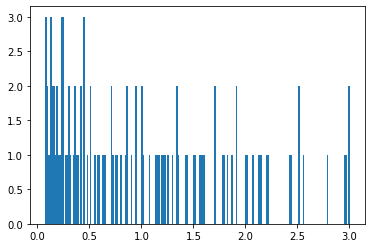

In [5]:
plt.hist(df["err_K"], bins=200)
plt.show()

In [9]:
np.max(df["logg"])

3.0

In [4]:
# figure out all subsets of coefficients beyond [a,b,c,d]

coeffs_strings = ["f","g","h","k","m","n"]
coeffs_strings_nan = ["NaN1"]
new_coeffs_6 = list(itertools.combinations(coeffs_strings, 6))
new_coeffs_5 = list(itertools.combinations(coeffs_strings, 5))
new_coeffs_4 = list(itertools.combinations(coeffs_strings, 4))
new_coeffs_3 = list(itertools.combinations(coeffs_strings, 3))
new_coeffs_2 = list(itertools.combinations(coeffs_strings, 2))
new_coeffs_1 = list(itertools.combinations(coeffs_strings, 1))
baseline = list(itertools.combinations(coeffs_strings_nan, 1)) # original Layden [a,b,c,d] coefficients only

In [7]:
# create the array of arrays, so we can map them across cores
new_coeffs_mother_array = [baseline,new_coeffs_1,new_coeffs_2,new_coeffs_3,new_coeffs_4,new_coeffs_5,new_coeffs_6]

In [8]:
def expanded_layden_all_coeffs(coeff_array,H,F):
    
    # definition of coefficients as of 2020 Mar 9:
    # K = a + bH + cF + dHF + f(H^{2}) + g(F^{2}) + hF(H^{2}) + kH(F^{2}) + m(H^{3}) + n(F^{3}) 
    
    a_coeff = coeff_array[0]
    b_coeff = coeff_array[1]
    c_coeff = coeff_array[2]
    d_coeff = coeff_array[3]
    f_coeff = coeff_array[4]
    g_coeff = coeff_array[5]
    h_coeff = coeff_array[6]
    k_coeff = coeff_array[7]
    m_coeff = coeff_array[8]
    n_coeff = coeff_array[9]
    
    K_calc = a_coeff + b_coeff*H + c_coeff*F + d_coeff*H*F + \
        f_coeff*np.power(H,2.) + g_coeff*np.power(F,2.) + \
        h_coeff*F*np.power(H,2.) + k_coeff*H*np.power(F,2.) + \
        m_coeff*np.power(H,3.) + n_coeff*np.power(F,3.)
    
    return K_calc

In [9]:
def original_layden_abcd(coeff_array,H,F):
    
    # definition of coefficients as of 2020 Mar 9:
    # K = a + bH + cF + dHF + f(H^{2}) + g(F^{2}) + hF(H^{2}) + kH(F^{2}) + m(H^{3}) + n(F^{3}) 
    
    a_coeff = coeff_array[0]
    b_coeff = coeff_array[1]
    c_coeff = coeff_array[2]
    d_coeff = coeff_array[3]
    
    K_calc = a_coeff + b_coeff*H + c_coeff*F + d_coeff*H*F
    
    return K_calc

In [10]:
def find_bic_of_1_subarray(new_coeffs_array):

    for t in range(0,len(new_coeffs_array)):
    
        print("----------")
        print("coefficients being tested:")
        print(new_coeffs_array[t])
    
        # initialize initial values to 1
        pinit = np.ones(10, dtype=np.float)

        # initialize bounds
        # elements represent, in order, [a,b,c,d,f,g,k,h,m,n]
        bounds_upper_array = (np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,np.inf)
        bounds_lower_array = (-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf)

        # convert to a list so values can be changed
        bounds_upper_array_list = list(bounds_upper_array)
        bounds_lower_array_list = list(bounds_lower_array)

        # if certain coefficients don't appear, set them to effectively zero
        if (new_coeffs_array[t].count("f") == 0):
            pinit[4] = 0
            bounds_upper_array_list[4] = 1e-40
            bounds_lower_array_list[4] = 0
        if (new_coeffs_array[t].count("g") == 0):
            pinit[5] = 0
            bounds_upper_array_list[5] = 1e-40
            bounds_lower_array_list[5] = 0
        if (new_coeffs_array[t].count("k") == 0):
            pinit[6] = 0
            bounds_upper_array_list[6] = 1e-40
            bounds_lower_array_list[6] = 0
        if (new_coeffs_array[t].count("h") == 0):
            pinit[7] = 0
            bounds_upper_array_list[7] = 1e-40
            bounds_lower_array_list[7] = 0
        if (new_coeffs_array[t].count("m") == 0):
            pinit[8] = 0
            bounds_upper_array_list[8] = 1e-40
            bounds_lower_array_list[8] = 0
        if (new_coeffs_array[t].count("n") == 0):
            pinit[9] = 0
            bounds_upper_array_list[9] = 1e-40
            bounds_lower_array_list[9] = 0
    
        # convert back to tuple
        bounds_upper_array = tuple(bounds_upper_array_list)
        bounds_lower_array = tuple(bounds_lower_array_list)
        bounds_array = [bounds_lower_array,bounds_upper_array]
    
        print("----------")
        print("bounds array:")
        print(bounds_array)

        # the error function
        errfunc_coeffs = lambda p, H, F, K, err_K: (K - expanded_layden_all_coeffs(p, H, F)) / err_K

        # the least-squares fit
        out = optimize.least_squares(errfunc_coeffs, pinit, bounds=bounds_array,
                       args=(df_choice["balmer"], df_choice["final_feh_center"], 
                             df_choice["K"], df_choice["err_K"]))

        pfinal = out.x
        print("----------")
        print("pfinal:")
        print(pfinal)

        #####################
        # calculate BIC
        # N.b. astropy BIC assumes Gaussian distribution
        # retrieved K values, using best-fit params
        retrieved_K = expanded_layden_all_coeffs(pfinal, df_choice["balmer"], df_choice["final_feh_center"])
        # 'sum of squared residuals between model and data'
        ssr = np.sum(np.power(np.subtract(df_choice["K"],retrieved_K),2.))
        # number of parameters that were actually varying
        n_params = len(np.where(np.abs(pfinal) > 1e-15)[0]) # [a,b,c,d] + ...
        # number of datapoints
        n_samples = len(df_choice["balmer"])
        bic = astropy.stats.bayesian_info_criterion_lsq(ssr, n_params, n_samples)
        print("----------")
        print("n_params:")
        print(n_params)
        print("n_samples:")
        print(n_samples)
        print("----------")
        print("BIC:")
        print(bic)
        print(pfinal[0])
        print(pfinal[1])
        print(pfinal[-1])
        #####################
        
        # generate random string to tag the plot
        N_string = 7
        res = ''.join(random.choices(string.ascii_uppercase +string.digits, k = N_string))
    
        # record in csv
        file_object = open(csv_file_name, 'a')
        file_object.write(str(new_coeffs_array[t])+";"+\
                          str(bic)+";"+\
                          str(n_params)+";"+\
                          str(ssr)+";"+\
                          str(n_samples)+";"+\
                          str(pfinal[0])+";"+\
                          str(pfinal[1])+";"+\
                          str(pfinal[2])+";"+\
                          str(pfinal[3])+";"+\
                          str(pfinal[4])+";"+\
                          str(pfinal[5])+";"+\
                          str(pfinal[6])+";"+\
                          str(pfinal[7])+";"+\
                          str(pfinal[8])+";"+\
                          str(pfinal[9])+\
                          "\n")
        # Close the file
        file_object.close()
    
        # make some isometallicity lines for the plot
        isometal_balmer_abcissa = np.arange(2,12,0.2)
        retrieved_K_isometal_neg3pt0 = expanded_layden_all_coeffs(pfinal, isometal_balmer_abcissa, -3.0)
        retrieved_K_isometal_neg2pt5 = expanded_layden_all_coeffs(pfinal, isometal_balmer_abcissa, -2.5)
        retrieved_K_isometal_neg2pt0 = expanded_layden_all_coeffs(pfinal, isometal_balmer_abcissa, -2.)
        retrieved_K_isometal_neg1pt5 = expanded_layden_all_coeffs(pfinal, isometal_balmer_abcissa, -1.5)
        retrieved_K_isometal_neg1pt0 = expanded_layden_all_coeffs(pfinal, isometal_balmer_abcissa, -1.)
        retrieved_K_isometal_neg0pt5 = expanded_layden_all_coeffs(pfinal, isometal_balmer_abcissa, -0.5)
        retrieved_K_isometal_pos0pt0 = expanded_layden_all_coeffs(pfinal, isometal_balmer_abcissa, -0.0)
        retrieved_K_isometal_pos0pt2 = expanded_layden_all_coeffs(pfinal, isometal_balmer_abcissa, -0.2)
    
        # plot it
        plt.clf()
        plt.figure(figsize=(20,10))
    
        # underplot isometallicity lines
        plt.plot(isometal_balmer_abcissa, retrieved_K_isometal_neg3pt0, linestyle="--", label="Isometal, Fe/H=-3.0")
        plt.plot(isometal_balmer_abcissa, retrieved_K_isometal_neg2pt5, linestyle="--", label="Isometal, Fe/H=-2.5")
        plt.plot(isometal_balmer_abcissa, retrieved_K_isometal_neg2pt0, linestyle="--", label="Isometal, Fe/H=-2.0")
        plt.plot(isometal_balmer_abcissa, retrieved_K_isometal_neg1pt5, linestyle="--", label="Isometal, Fe/H=-1.5")
        plt.plot(isometal_balmer_abcissa, retrieved_K_isometal_neg1pt0, linestyle="--", label="Isometal, Fe/H=-1.0")
        plt.plot(isometal_balmer_abcissa, retrieved_K_isometal_neg0pt5, linestyle="--", label="Isometal, Fe/H=-0.5")
        plt.plot(isometal_balmer_abcissa, retrieved_K_isometal_pos0pt0, linestyle="--", label="Isometal, Fe/H=+0.0")
        plt.plot(isometal_balmer_abcissa, retrieved_K_isometal_pos0pt2, linestyle="--", label="Isometal, Fe/H=+0.2")
    
        # data points
        #print(len(df_choice["final_feh_center"]))
        plt.scatter(df_choice["balmer"], df_choice["K"], label="Empirical")
        plt.scatter(df_choice["balmer"], retrieved_K, 
            label="Retrieved, Modified Layden eqn")
        # connect the empirical-retrieved dots, using list comprehension
        [plt.plot([df_choice["balmer"][j],df_choice["balmer"][j]],
                  [df_choice["K"][j],retrieved_K[j]], color="k") for j in range(len(df_choice["final_feh_center"]))]
        plt.ylabel("K EW ($\AA$)")
        plt.xlabel("Balmer EW ($\AA$)")
        plt.title(str(new_coeffs_array[t]) + "\nBIC = " + str(bic))
        plt.legend()
        plt.savefig("plot_"+res+".pdf")
        plt.close()

        print("----------")
        print("----------")

In [13]:
# map the function across all available cores
ncpu = multiprocessing.cpu_count()
pool = multiprocessing.Pool(ncpu)
pool.map(find_bic_of_1_subarray, new_coeffs_mother_array)

----------
----------
coefficients being tested:
coefficients being tested:
----------
----------
coefficients being tested:
('f', 'g')
('NaN1',)
('f',)
coefficients being tested:
----------
----------
----------
('f', 'g', 'h')
bounds array:
bounds array:
bounds array:
----------
[(-inf, -inf, -inf, -inf, -inf, 0, 0, 0, 0, 0), (inf, inf, inf, inf, inf, 1e-40, 1e-40, 1e-40, 1e-40, 1e-40)]
[(-inf, -inf, -inf, -inf, -inf, -inf, 0, 0, 0, 0), (inf, inf, inf, inf, inf, inf, 1e-40, 1e-40, 1e-40, 1e-40)]
[(-inf, -inf, -inf, -inf, 0, 0, 0, 0, 0, 0), (inf, inf, inf, inf, 1e-40, 1e-40, 1e-40, 1e-40, 1e-40, 1e-40)]
bounds array:
[(-inf, -inf, -inf, -inf, -inf, -inf, 0, -inf, 0, 0), (inf, inf, inf, inf, inf, inf, 1e-40, inf, 1e-40, 1e-40)]
----------
pfinal:
[ 1.61264126e+01 -1.02592962e+00  6.98012066e+00 -2.59588500e-01
  1.39979876e-02  7.01457973e-01  5.00000000e-41  5.00000000e-41
  5.00000000e-41  5.00000000e-41]
----------
n_params:
6
n_samples:
108
----------
BIC:
-24.829810503451526
16.12

Process ForkPoolWorker-17:
Traceback (most recent call last):
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/connection.py", line 379, in _r

KeyboardInterrupt: 

Process ForkPoolWorker-18:
Traceback (most recent call last):
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "<ipython-input-10-cd3b4b464528>", line 62, in find_bic_of_1_subarray
    df_choice["K"], df_choice["err_K"]))
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/scipy/optimize/_lsq/least_squares.py", line 908, in least_squares
    tr_options.copy(), verbose)
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/scipy/optimize/_lsq/

  File "pandas/_libs/ops_dispatch.pyx", line 91, in pandas._libs.ops_dispatch.maybe_dispatch_ufunc_to_dunder_op
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/pandas/core/ops/common.py", line 64, in new_method
    return method(self, other)
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/pandas/core/ops/__init__.py", line 502, in wrapper
    return _construct_result(left, result, index=left.index, name=res_name)
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/pandas/core/ops/__init__.py", line 475, in _construct_result
    out = left._constructor(result, index=index)
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/pandas/core/series.py", line 305, in __init__
    data = sanitize_array(data, index, dtype, copy, raise_cast_failure=True)
  File "/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/pandas/core/construction.py", line 486, in sanitize_array
    if not (is_extensio

In [9]:
# baseline check

'''
abcd_older = [12.513685,-0.78716521,3.8778512,-0.24297523]
abcd_now = [1.21768692e+01,-7.52340434e-01,3.76117382e+00,-2.30912220e-01]
K_baseline = original_layden_abcd(coeff_array=abcd_older,H=df_choice["balmer"],F=df_choice["final_feh_center"])

ssr = np.sum(np.power(np.subtract(df_choice["K"],K_baseline),2.))
n_params = 4
n_samples = len(df_choice["balmer"])
bic = astropy.stats.bayesian_info_criterion_lsq(ssr, n_params, n_samples)
print(bic)
'''

245.14650102961204


### Compare BICs

In [6]:
'''
BIC_orig = 245.1464970126952
BIC_1_f = 245.36213036898667
BIC_2_g = 197.42180787854656
BIC_3_h = 226.17141772986807
BIC_4_fg = 196.28752773438762
BIC_5_fh = 226.36328694853378
BIC_6_gh = 203.0216458555668
BIC_7_fgh = 116.29437000510694

print("$\Delta$ BIC_1_f, BIC_orig:")
print(np.subtract(BIC_1_f,BIC_orig))
print("------")
print("$\Delta$ BIC_2_g, BIC_orig:")
print(np.subtract(BIC_2_g,BIC_orig))
print("------")
print("$\Delta$ BIC_3_h, BIC_orig:")
print(np.subtract(BIC_3_h,BIC_orig))
print("------")
print("$\Delta$ BIC_4_fg, BIC_orig:")
print(np.subtract(BIC_4_fg,BIC_orig))
print("------")
print("$\Delta$ BIC_5_fh, BIC_orig:")
print(np.subtract(BIC_5_fh,BIC_orig))
print("------")
print("$\Delta$ BIC_6_gh, BIC_orig:")
print(np.subtract(BIC_6_gh,BIC_orig))
print("------")
print("$\Delta$ BIC_7_fgh, BIC_orig:")
print(np.subtract(BIC_7_fgh,BIC_orig))
print("------")
'''

$\Delta$ BIC_1_f, BIC_orig:
0.21563335629147673
------
$\Delta$ BIC_2_g, BIC_orig:
-47.72468913414863
------
$\Delta$ BIC_3_h, BIC_orig:
-18.975079282827124
------
$\Delta$ BIC_4_fg, BIC_orig:
-48.85896927830757
------
$\Delta$ BIC_5_fh, BIC_orig:
-18.78321006416141
------
$\Delta$ BIC_6_gh, BIC_orig:
-42.124851157128404
------
$\Delta$ BIC_7_fgh, BIC_orig:
-128.85212700758825
------


In [54]:
# Find some metallicities
'''
H = df_choice["balmer"]
K = df_choice["K"]

## calculate retrieved Fe/H using solution with [a,b,c,d,f,g,h]
modified_soln_7_abcdfgh = [16.92437966,-0.98640101,5.2261726,0.53344007,-0.06341921,0.27027538,-0.02034332]

coeff_a = modified_soln_7_abcdfgh[0]
coeff_b = modified_soln_7_abcdfgh[1]
coeff_c = modified_soln_7_abcdfgh[2]
coeff_d = modified_soln_7_abcdfgh[3]
coeff_f = modified_soln_7_abcdfgh[4]
coeff_g = modified_soln_7_abcdfgh[5]
coeff_h = modified_soln_7_abcdfgh[6]

A_cap = coeff_g*H + coeff_h*np.power(H,2)
B_cap = coeff_c + coeff_d*H + coeff_f*np.power(H,2)
C_cap = -K + coeff_a + coeff_b*H

F_pos = np.divide(-B_cap + np.sqrt(np.power(B_cap,2.)-4*A_cap*C_cap),2*A_cap)
F_neg = np.divide(-B_cap - np.sqrt(np.power(B_cap,2.)-4*A_cap*C_cap),2*A_cap)


## and calculate retrieved Fe/H using just [a,b,c,d] (the Layden fit, but with our best-fit values)
original_layden_our_fit_soln_0_abcd = [12.51368502,-0.78716519,3.87785117,-0.24297523]
coeff_a_original = original_layden_our_fit_soln_0_abcd[0]
coeff_b_original = original_layden_our_fit_soln_0_abcd[1]
coeff_c_original = original_layden_our_fit_soln_0_abcd[2]
coeff_d_original = original_layden_our_fit_soln_0_abcd[3]
F_original_our_fit = np.divide(K-coeff_a_original-coeff_b_original*H,coeff_c_original+coeff_d_original*H)

plt.clf()
plt.scatter(df_choice["final_feh_center"],F_original_our_fit,facecolors="none",
            edgecolors="k",label="Layden-style abcd")
plt.scatter(df_choice["final_feh_center"],F_pos,facecolors="orange",edgecolors="r",
            label="Modified abcdfgh: positive soln")
for i in range(0,len(df)):
    plt.annotate(df["original_spec_file_name"].iloc[i], 
                 xy=(df["final_feh_center"].iloc[i],F_pos.iloc[i]), 
                 xytext=(df["final_feh_center"].iloc[i],F_pos.iloc[i]))
plt.scatter(df_choice["final_feh_center"],F_neg,label="Modified abcdfgh: negative soln")
plt.plot([-3,2],[-3,2],linestyle="--")
plt.xlabel("Injected Fe/H")
plt.ylabel("Retrieved Fe/H")
plt.legend()
plt.show()
'''

/Users/nyumbani/anaconda3/envs/py366/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
# Find some metallicities
H = df_choice["balmer"]
K = df_choice["K"]

## calculate retrieved Fe/H using solution with [a,b,c,d,f,g,h,k], using logg3pt0_bic_output_20200322.csv
modified_soln_7_abcdfghk = [20.268216020772577,-2.103240677086597,9.682756160690241,-0.7990904214384392,0.07262757512570928,1.1242402933493127,0.020811006600471953,-0.05460696008885377]

coeff_a = modified_soln_7_abcdfghk[0]
coeff_b = modified_soln_7_abcdfghk[1]
coeff_c = modified_soln_7_abcdfghk[2]
coeff_d = modified_soln_7_abcdfghk[3]
coeff_f = modified_soln_7_abcdfghk[4]
coeff_g = modified_soln_7_abcdfghk[5]
coeff_h = modified_soln_7_abcdfghk[6]
coeff_k = modified_soln_7_abcdfghk[7]

A_cap = coeff_g + coeff_k*H
B_cap = coeff_c + coeff_d*H + coeff_h*np.power(H,2)
C_cap = coeff_a + coeff_b*H + coeff_f*np.power(H,2) - K

F_pos = np.divide(-B_cap + np.sqrt(np.power(B_cap,2.)-4*A_cap*C_cap),2*A_cap)
F_neg = np.divide(-B_cap - np.sqrt(np.power(B_cap,2.)-4*A_cap*C_cap),2*A_cap)


## and calculate retrieved Fe/H using just [a,b,c,d] (the Layden fit, but with our best-fit values)
original_layden_our_fit_soln_0_abcd = [12.51368502,-0.78716519,3.87785117,-0.24297523]
coeff_a_original = original_layden_our_fit_soln_0_abcd[0]
coeff_b_original = original_layden_our_fit_soln_0_abcd[1]
coeff_c_original = original_layden_our_fit_soln_0_abcd[2]
coeff_d_original = original_layden_our_fit_soln_0_abcd[3]
F_original_our_fit = np.divide(K-coeff_a_original-coeff_b_original*H,coeff_c_original+coeff_d_original*H)

plt.clf()
plt.scatter(df_choice["final_feh_center"],F_original_our_fit,facecolors="none",
            edgecolors="k",label="Layden-style abcd")
plt.scatter(df_choice["final_feh_center"],F_pos,facecolors="orange",edgecolors="r",
            label="Modified abcdfghk: positive soln")
'''
for i in range(0,len(df)):
    plt.annotate(df["original_spec_file_name"].iloc[i], 
                 xy=(df["final_feh_center"].iloc[i],F_pos.iloc[i]), 
                 xytext=(df["final_feh_center"].iloc[i],F_pos.iloc[i]))
'''
plt.scatter(df_choice["final_feh_center"],F_neg,label="Modified abcdfghk: negative soln")
plt.title("Fe/H retrievals based on solutions in logg3pt0_bic_output_20200322.csv")
plt.plot([-3,2],[-3,2],linestyle="--")
plt.xlabel("Injected Fe/H")
plt.ylabel("Retrieved Fe/H")
plt.legend()
plt.show()

In [15]:
plt.clf()
plt.scatter(df_choice["final_feh_center"],np.sqrt(np.power(B_cap,2.)-4*A_cap*C_cap),label="+sqrt(B^2-4AC)")
plt.scatter(df_choice["final_feh_center"],-np.sqrt(np.power(B_cap,2.)-4*A_cap*C_cap),label="-sqrt(B^2-4AC)")
#plt.scatter(df_choice["final_feh_center"],A_cap,label="A")
plt.scatter(df_choice["final_feh_center"],-B_cap,label="-B")
plt.legend()
plt.show()